# Function Definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import Adam
from keras.utils import plot_model
from math import floor

RNG = np.random.default_rng()

'''
    generate_random_linear_equations
'''
def generate_random_linear_equations(n, as_string=False):

    # generate two rngs so that they can be seeded correctly
    # Use a separate rng for this

    # generate 2 rngs with the same seed
    equations = []
    for _ in range(n):
        m = RNG.integers(-20, 20)  # Random slope between -100 and 100
        b = RNG.integers(-20, 20)  # Random y-intercept between -100 and 100

        if as_string:
            equations.append(f'{m}x+{b}' if b >= 0 else f'{m}x{b}')
        else:
            equations.append([m,b])

    return np.array(equations)

'''
    define_grammar:

    This function creates the grammar production rules for use in the grammatical evolution technique.
    This grammar production rule is inspired from the WHGE paper as a simple grammar evolution for testing.
'''
def define_grammar():
    G = {}
    G['expr'] = [['expr', 'op', 'expr'], ['num'], ['num', 'num'], ['var']]
    G['op']   = ['+', '-']
    G['var']  = ['x']
    G['num']  = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    return G

'''
    evaluate_individual
'''
def evaluate_individual(G: dict, genome: list[int], S: list[str]=['expr'], verbose=False) -> str:
    F = []
    R = list(S)
    pointer = 0
    max_iterations = 1000  # Set a reasonable max to prevent infinite loops
    iteration = 0

    if verbose:
        print(f'Initial R: {R} | F: {F}')

    while len(R) > 0 and iteration < max_iterations:
        symbol = R.pop(0)  # evaluate the first symbol
        if symbol not in G:  # Directly append if it's a terminal
            F.append(symbol)
            continue
        codon = genome[pointer]
        choices = G[symbol]
        lookup = choices[codon % len(choices)]
        if not isinstance(lookup, list):
            F.append(lookup)
        else:
            lookup.reverse()
            for l in lookup:
                R.insert(0, l)

        if verbose:
            print(f'Iteration {iteration}: R: {R} | F: {F}')

        # update position in the genome, reset if we've reached the end
        pointer = (pointer + 1) % len(genome)
        iteration += 1

    if iteration >= max_iterations and verbose:
        print("Evaluation terminated due to too many iterations.")
        return ''.join(F)  # or handle this case differently

    return ''.join(F)

def reduce_linear_equation(equation):
    # Remove whitespaces and handle equals sign
    equation = equation.replace(" ", "").split("=")[0]
    
    # Find all terms involving 'x' and constant terms
    x_terms = re.findall(r'([+-]?\d*)x', equation)
    constant_terms = re.findall(r'([+-]?\d+)(?![x\d])', equation)
    
    # Sum the coefficients of 'x'
    x_coefficient = sum(int(term+'1') if term in ['+', ''] else int(term+'1') if term == '-' else int(term) for term in x_terms)
    
    # Sum the constant terms
    total_constant = sum(int(term) for term in constant_terms)
    
    # Correct formatting for x coefficient
    x_part = f"{x_coefficient}x"# if x_coefficient != 1 and x_coefficient != -1 else ("x" if x_coefficient == 1 else "-x")
    
    # Always format b, even if it is zero
    constant_part = f"+{total_constant}" if total_constant >= 0 else f"{total_constant}"
    
    # Combine parts to form the compact equation
    compact_equation = f"{x_part}{constant_part}"
    
    return compact_equation

'''
    create_equation_model

    This function creates a dense network using tensorflow where the inputs are the sequence of genes of a 
    particular individual. This individual trains on the network and produces an output of 2, the m,b parameters
    of a linear equation.

    genome_len: The length of the bit string: int
    learning_rate: Learning rate of the model: float
    verbose: Whether the model should print verbose information during processing: bool

    Returns a Tensorflow Model object.
'''
def create_equation_model(genome_len: int=5, lrate: float=0.001, verbose: bool=True) -> Model:

    # define the hyperparameters not being passed in
    layer_sizes = [32, 64, 128]

    # Create the input layer. This is a n-length vector the length of the genome.
    input_shape = (genome_len,)
    input = Input(shape=input_shape)
    tensor = input

    # Create the dense layers for the network
    for layer in layer_sizes:
        tensor = Dense(layer, activation='elu')(tensor)

    # Add the output layer; this layer represents the equation parameters, so 2 outputs are needed
    tensor = Dense(2, activation='linear')(tensor)

    # Create a model from the tensor transforms; add the optimizer and compile
    model = Model(inputs=input, outputs=tensor)
    opt = Adam(learning_rate=lrate)
    model.compile(optimizer=opt, loss='mse', metrics=[])

    # print a summary if desired
    if verbose:
        print(model.summary())

    # return the compiled model
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    return model

'''
    returns a fitness score that is better the closer to 0 you are
'''
def calculate_fitness(actual: str, target: str):

    split_pattern = r'x[\+\-]'
    actual_split = re.split(split_pattern, actual)
    target_split = re.split(split_pattern, target)

    # add a small amount of random noise
    noise = RNG.random()
    return noise + np.abs(int(actual_split[0]) - int(target_split[0])) + np.abs(int(actual_split[1]) - int(target_split[1]))

2024-05-02 19:42:35.871022: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 19:42:35.906477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 19:42:35.906502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 19:42:35.907533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 19:42:35.913755: I tensorflow/core/platform/cpu_feature_guar

# ANN Experiment

In [2]:
def run_ann_exp(test_population, test_equations, genome_len=50, population_size=100):

    # Create random linear equations. These equations are meant to be valid outputs of programs
    train_labels = test_equations #generate_random_linear_equations(population_size)
    train_pop = np.array([[floor(RNG.uniform(0,256)) for _ in range(genome_len)] for _ in range(population_size)])

    model = create_equation_model(genome_len=genome_len)
    model.fit(train_pop, train_labels, epochs=1000)

    model.save('./ann_model.keras')
    results = np.floor(model.predict(test_population))

    dtype = [('col1', results.dtype), ('col2', test_equations.dtype)]
    structured_array1 = np.array(list(map(tuple, results)), dtype=dtype)
    structured_array2 = np.array(list(map(tuple, test_equations)), dtype=dtype)

    common_structured_rows = np.intersect1d(structured_array1, structured_array2)

    # Convert back to regular 2D array if needed
    common_results = np.array(common_structured_rows.tolist())
    print(common_results)

    return common_results

# GE Experiment

In [3]:
def run_ge_exp(initial_population, target_equation, genome_len=50, population_size=100):

    # Define parameters:
    num_generations = 1000
    save_rate = 0.05
    drop_rate = 0.05
    population_size = 100

    # Derived Parameters
    num_save = floor(population_size * save_rate)
    num_drop = floor(population_size * drop_rate)

    # Save the results for graphing.
    results = []
    fitnesses = []
    mean_fitnesses = []

    # Create the initial population
    population = initial_population.copy()

    # Set the start expression, define the grammar
    S = ['expr']
    G = define_grammar()

    for generation in range(num_generations):

        # Take the population and evaluate the fitness scores
        results = [reduce_linear_equation(o) for o in [evaluate_individual(G, individual, S) for individual in population]]
        fitnesses = [calculate_fitness(result, target_equation) for result in results]
        mean_fitnesses.append(np.mean(fitnesses))

        if target_equation in results:
            print(f'FOUND in {generation} generations...')
            return generation

        # Create a new population list
        new_pop = []

        # Sort the population by fitness score
        indices = np.argsort(fitnesses)
        population = population[indices]

        # Pop the top X% into the new population; drop them from the original list
        new_pop = population[0:num_save,:]
        population = population[num_save:,:]

        # Drop the bottom Y% from the population
        population = population[:-num_drop, :]

        # Perform crossover on the remainders
        RNG.shuffle(population)
        while len(population) >= 2:
            left = population[0,:]
            right = population[1,:]

            # swap the two genomes
            swap = left
            left = right
            right = swap

            swap = left
            left = right
            right = swap

            # Add the two new genes to the new population;
            # remove the two from the old population
            left = left.reshape((1,genome_len))
            right = right.reshape((1,genome_len))
            new_pop = np.concatenate((new_pop, left, right), axis=0)
            population = population[2:,]

        # Generate random values to fill the population
        new_pop = np.concatenate((new_pop, np.array([[floor(RNG.uniform(0,256)) for _ in range(genome_len)] for _ in range(population_size - len(new_pop))])))
        population = new_pop

    # Default return if it was not found
    return -1

# Experimental Setup and Results

## Experiment

In [4]:
genome_len = 50
population_size = 100
equations = generate_random_linear_equations(100)
equations_str = [f'{e[0]}x+{e[1]}' if e[1] >= 0 else f'{e[0]}x{e[1]}' for e in equations]
init_pop = np.array([[floor(RNG.uniform(0,256)) for _ in range(genome_len)] for _ in range(population_size)])

ge_results = []
ann_results = []
exp_to_run = 10

for _ in range(exp_to_run):
    results = np.array([run_ge_exp(initial_population=init_pop, target_equation=equation) for equation in equations_str])
    ge_results.append(len(results[results != -1]))

    results2 = run_ann_exp(init_pop, equations)
    ann_results.append(results2.shape[0])

FOUND in 30 generations...
FOUND in 0 generations...
FOUND in 83 generations...
FOUND in 345 generations...
FOUND in 903 generations...
FOUND in 197 generations...
FOUND in 0 generations...
FOUND in 749 generations...
FOUND in 672 generations...
FOUND in 3 generations...
FOUND in 409 generations...
FOUND in 948 generations...
FOUND in 163 generations...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                   

2024-05-02 19:44:28.020381: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-02 19:44:28.020420: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: zak-tensortitan
2024-05-02 19:44:28.020423: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: zak-tensortitan
2024-05-02 19:44:28.020553: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-05-02 19:44:28.020562: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-05-02 19:44:28.020564: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.161.7


4/4 [==============================] - 0s 3ms/step - loss: 9841.1123
Epoch 2/1000
4/4 [==============================] - 0s 1ms/step - loss: 762.0609
Epoch 3/1000
4/4 [==============================] - 0s 1ms/step - loss: 1387.7886
Epoch 4/1000
4/4 [==============================] - 0s 1ms/step - loss: 1376.7640
Epoch 5/1000
4/4 [==============================] - 0s 1ms/step - loss: 553.1837
Epoch 6/1000
4/4 [==============================] - 0s 1ms/step - loss: 214.2018
Epoch 7/1000
4/4 [==============================] - 0s 1ms/step - loss: 316.1447
Epoch 8/1000
4/4 [==============================] - 0s 1ms/step - loss: 344.8882
Epoch 9/1000
4/4 [==============================] - 0s 1ms/step - loss: 227.5206
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step - loss: 145.8409
Epoch 11/1000
4/4 [==============================] - 0s 2ms/step - loss: 136.6834
Epoch 12/1000
4/4 [==============================] - 0s 1ms/step - loss: 142.7482
Epoch 13/1000
4/4 [================

KeyboardInterrupt: 

## Results

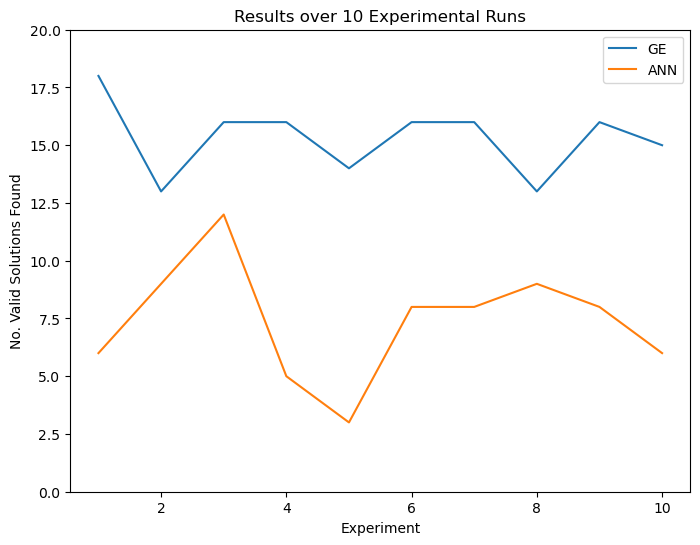

In [ ]:
x = [r + 1 for r in range(exp_to_run)]

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(x, ge_results, label='GE')
ax.plot(x, ann_results, label='ANN')
ax.set_title('Results over 10 Experimental Runs')
ax.set_xlabel('Experiment')
ax.set_ylabel('No. Valid Solutions Found')
ax.set_ybound(0, 20)
ax.legend()


In [ ]:
ge_results

NameError: name 'ge_results' is not defined